# Others NLP Techniques - Extracting Information from Text

That notebook is the follow-up to [Chapter 7](http://www.nltk.org/book/ch07.html) of *NLTK book
(“Extracting Information from Text”, Natural Language Processing with Python. Analyzing
Text with the Natural Language Toolkit. Steven Bird, Ewan Klein, and Edward Loper, [online book](http://www.nltk.org/book/))*

In [1]:
%pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

import numpy as np
import nltk

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## 2. Chunking

The basic technique we will use for entity detection is chunking, which segments and labels multi-token sequences as illustrated in the following image:

<img src="img/chunk-segmentation.png" alt="Drawing" style="width: 450px;"/>

The smaller boxes show the word-level tokenization and part-of-speech tagging, while the large boxes show higher-level chunking. Each of these larger boxes is called a chunk. Like tokenization, which omits whitespace, chunking usually selects a subset of the tokens. Also like tokenization, the pieces produced by a chunker do not overlap in the source text.

### 2.1. Noun Phrase Chunking

We will begin by considering the task of **noun phrase chunking**, or **NP-chunking**, where we search for chunks corresponding to individual noun phrases. For example, here is some Wall Street Journal text with NP-chunks marked using brackets:

    (2)	[ The/DT market/NN ] for/IN [ system-management/NN software/NN ] for/IN [ Digital/NNP ] [ 's/POS hardware/NN ] is/VBZ fragmented/JJ enough/RB that/IN [ a/DT giant/NN ] such/JJ as/IN [ Computer/NNP Associates/NNPS ] should/MD do/VB well/RB there/RB ./.

As we can see, NP-chunks are often smaller pieces than complete noun phrases. One of the motivations for this difference is that NP-chunks are defined so as not to contain other NP-chunks.

One of the most useful sources of information for NP-chunking is part-of-speech tags. This is one of the motivations for performing part-of-speech tagging in our information extraction system. We demonstrate this approach using an example sentence that has been part-of-speech tagged in following code.

(S
  (NP the/DT little/JJ yellow/JJ dog/NN)
  barked/VBD
  at/IN
  (NP the/DT cat/NN))


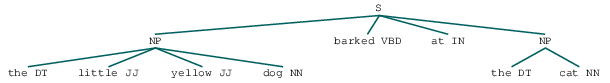

In [2]:
# Example sentence that has been part-of-speech tagged
sentence = [("the", "DT"), ("little", "JJ"), ("yellow", "JJ"), 
            ("dog", "NN"), ("barked", "VBD"), ("at", "IN"),  
            ("the", "DT"), ("cat", "NN")]

# Define a chunk grammar (consisting of rules than indicate how sentences should be chunked).
# That grammar is defnied with a single regular-expression rule:
grammar = "NP: {<DT>?<JJ>*<NN>}"
# This rule says that an NP chunk should be formed whenever the chunker finds 
#  an optional determiner (DT) followed by any number of adjectives (JJ) and then a noun (NN).


# Create a Chunk Parser using RegexpParser class
chunk_parser = nltk.RegexpParser(grammar)

# Parse the example sentence
result = chunk_parser.parse(sentence)

# Print the result
print(result)
result

The rules that make up a chunk grammar use **tag patterns** to describe sequences of tagged words. A tag pattern is a sequence of part-of-speech tags delimited using angle brackets, e.g. `<DT>?<JJ>*<NN>`. Tag patterns are similar to regular expression patterns.

Chunk grammar can be more complex, like that example:

(S
  (NP Rapunzel/NNP)
  let/VBD
  down/RP
  (NP her/PP$ long/JJ golden/JJ hair/NN))


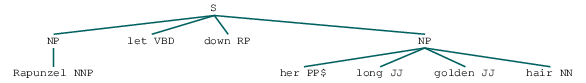

In [3]:
sentence = [("Rapunzel", "NNP"), ("let", "VBD"), ("down", "RP"),
            ("her", "PP$"), ("long", "JJ"), ("golden", "JJ"), ("hair", "NN")]

grammar = r"""
    NP: {<DT|PP\$>?<JJ>*<NN>} # chunk determiner/possessive, adjectives and noun
        {<NNP>+}              # chunk sequences of proper nouns
"""

chunk_parser = nltk.RegexpParser(grammar)

print(chunk_parser.parse(sentence))
chunk_parser.parse(sentence)

### 2.6. Representing Chunks: Tags vs Trees 

As befits their intermediate status between tagging and parsing ([Chatper 8](https://www.nltk.org/book/ch08.html#chap-parse)), chunk structures can be represented using either tags or trees. The most widespread file representation uses **IOB tags**. 

In this scheme, each token is tagged with one of three special chunk tags, `I` (inside), `O` (outside), or `B` (begin). A token is tagged as `B` if it marks the beginning of a chunk. Subsequent tokens within the chunk are tagged `I`. All other tokens are tagged `O`. The `B` and `I` tags are suffixed with the chunk type, e.g. `B-NP`, `I-NP`. 

Of course, it is not necessary to specify a chunk type for tokens that appear outside a chunk, so these are just labeled `O`. An example of this scheme is shown in the following image:

<img src="img/chunk-tagrep.png" alt="Drawing" style="width: 450px;"/>

IOB tags have become the standard way to represent chunk structures in files, and we will also be using this format. Here is how the information in the last image would appear in a file:

    We PRP B-NP
    saw VBD O
    the DT B-NP
    yellow JJ I-NP
    dog NN I-NP

In this representation there is one token per line, each with its part-of-speech tag and chunk tag. This format permits us to represent more than one chunk type, so long as the chunks do not overlap. 

## 3. Developing and Evaluating Chunkers

### 3.1. Reading IOB Format and the CoNLL 2000 Corpus

Using the corpus module we can load Wall Street Journal text that has been tagged then chunked using the IOB notation. The chunk categories provided in this corpus are `NP`, `VP` and `PP`. As we have seen, each sentence is represented using multiple lines, as shown below:

    he PRP B-NP
    accepted VBD B-VP
    the DT B-NP
    position NN I-NP
    ...
    
A conversion function `chunk.conllstr2tree()` builds a tree representation from one of these multi-line strings. Moreover, it permits us to choose any subset of the three chunk types to use, here just for NP chunks:

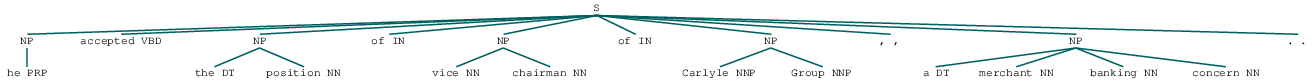

In [4]:
# Example of file on IOB notation
text = '''
he PRP B-NP
accepted VBD B-VP
the DT B-NP
position NN I-NP
of IN B-PP
vice NN B-NP
chairman NN I-NP
of IN B-PP
Carlyle NNP B-NP
Group NNP I-NP
, , O
a DT B-NP
merchant NN I-NP
banking NN I-NP
concern NN I-NP
. . O
'''

# Execute the conversion function
nltk.chunk.conllstr2tree(text, chunk_types=['NP'])

We can use the NLTK corpus module to access a larger amount of chunked text. The CoNLL 2000 corpus contains 270k words of Wall Street Journal text, divided into "train" and "test" portions, annotated with part-of-speech tags and chunk tags in the IOB format. We can access the data using `nltk.corpus.conll2000`. Here is an example that reads the 100th sentence of the "train" portion of the corpus:



(S
  (PP Over/IN)
  (NP a/DT cup/NN)
  (PP of/IN)
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  (VP told/VBD)
  (NP his/PRP$ story/NN)
  ./.)
(S
  Over/IN
  (NP a/DT cup/NN)
  of/IN
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  told/VBD
  (NP his/PRP$ story/NN)
  ./.)


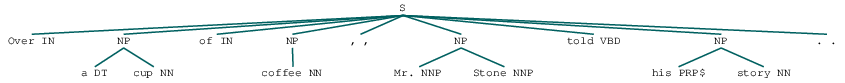

In [5]:
# Import CoNLL 2000
from nltk.corpus import conll2000

# Print the 100th sentence 
print(conll2000.chunked_sents('train.txt')[99])
conll2000.chunked_sents('train.txt')[99]


# Also, we can use the 'chuck_types' to select the chunk types that we want:
print(conll2000.chunked_sents('train.txt', chunk_types=['NP'])[99])
conll2000.chunked_sents('train.txt', chunk_types=['NP'])[99]

### 3.2 Simple Evaluation and Baselines 

Now that we can access a chunked corpus, we can evaluate chunkers. We start off by establishing a baseline for the trivial chunk parser `chunk_parser` that creates no chunks:

In [6]:
# Import CoNLL200
from nltk.corpus import conll2000

# Create the empty chunk parser
chunk_parser = nltk.RegexpParser("")

# Get the test sentences with NP-chunks
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])

# Evaluate the empty chunk parser
print(chunk_parser.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  43.4%%
    Precision:      0.0%%
    Recall:         0.0%%
    F-Measure:      0.0%%


The IOB tag accuracy indicates that more than a third of the words are tagged with `O`, i.e. not in an NP chunk. However, since our tagger did not find any chunks, its precision, recall, and f-measure are all zero. Now let's try a naive regular expression chunker that looks for tags beginning with letters that are characteristic of noun phrase tags (e.g. `CD`, `DT`, and `JJ`).

In [7]:
# Create the grammar
grammar = r"NP: {<[CDJNP].*>+}"

# Create the chunk parser
chunk_parser = nltk.RegexpParser(grammar)

# Evaluate the chunk parser
print(chunk_parser.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  87.7%%
    Precision:     70.6%%
    Recall:        67.8%%
    F-Measure:     69.2%%


As you can see, this approach achieves decent results. However, we can improve on it by adopting a more data-driven approach, where we use the training corpus to find the chunk tag (`I`,  `O`, or `B`) that is most likely for each part-of-speech tag. In other words, we can build a chunker using a *unigram tagger* ([Chatper 5](https://www.nltk.org/book/ch05.html#sec-automatic-tagging)). But rather than trying to determine the correct part-of-speech tag for each word, we are trying to determine the correct chunk tag, given each word's part-of-speech tag.

#### UnigramChunker class 

We define the `UnigramChunker` class, which uses a unigram tagger to label sentences with chunk tags. Most of the code in this class is simply used to convert back and forth between the chunk tree representation used by NLTK's `ChunkParserI` interface, and the `IOB` representation used by the embedded tagger. The class defines two methods: a constructor which is called when we build a new `UnigramChunker`; and the parse method which is used to chunk new sentences.

In [8]:
class UnigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents): 
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents]
        self.tagger = nltk.UnigramTagger(train_data) 

    def parse(self, sentence):
        pos_tags = [pos for (word,pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word,pos),chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

The constructor expects a list of training sentences, which will be in the form of chunk trees. It first converts training data to a form that is suitable for training the tagger, using  `tree2conlltags` to map each chunk tree to a list of `word,tag,chunk` triples. It then uses that converted training data to train a unigram tagger, and stores it in `self.tagger` for later use.

The `parse` method takes a tagged sentence as its input, and begins by extracting the part-of-speech tags from that sentence. It then tags the part-of-speech tags with `IOB` chunk tags, using the tagger `self.tagger` that was trained in the constructor. Next, it extracts the chunk tags, and combines them with the original sentence, to yield `conlltags`. Finally, it uses `conlltags2tree` to convert the result back into a chunk tree.

Now that we have `UnigramChunker`, we can train it using the CoNLL 2000 corpus, and test its resulting performance:

In [9]:
# Get the train and test corpus
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])

# Create the UnigramChunker
unigram_chunker = UnigramChunker(train_sents)

# Print the evaluation
print(unigram_chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


This chunker does reasonably well, achieving an overall f-measure score of 83%.

#### BigramChunker class 

Having built a unigram chunker, it is quite easy to build a bigram chunker:

In [10]:
class BigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents): 
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents]
        self.tagger = nltk.BigramTagger(train_data) 

    def parse(self, sentence):
        pos_tags = [pos for (word,pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word,pos),chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

The resulting chunker has slightly higher performance than the unigram chunker:

In [11]:
# Get the train and test corpus
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])

# Create the UnigramChunker
bigram_chunker = BigramChunker(train_sents)

# Print the evaluation
print(bigram_chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  93.3%%
    Precision:     82.3%%
    Recall:        86.8%%
    F-Measure:     84.5%%


### 3.3. Training Classifier-Based Chunkers

Both the regular-expression based chunkers and the n-gram chunkers decide what chunks to create entirely based on part-of-speech tags. However, sometimes part-of-speech tags are insufficient to determine how a sentence should be chunked. For example, consider the following two statements:


    a. Joey/NN sold/VBD the/DT farmer/NN rice/NN ./.

    b. Nick/NN broke/VBD my/DT computer/NN monitor/NN ./.


These two sentences have the same part-of-speech tags, yet they are chunked differently. In the first sentence, *the farmer and rice* are separate chunks, while the corresponding material in the second sentence, *the computer monitor*, is a single chunk. Clearly, we need to make use of information about the content of the words, in addition to just their part-of-speech tags, if we wish to maximize chunking performance.

One way that we can incorporate information about the content of words is to use a classifier-based tagger to chunk the sentence. Like the n-gram chunker considered in the previous section, this classifier-based chunker will work by assigning IOB tags to the words in a sentence, and then converting those tags to chunks. For the classifier-based tagger itself, we will use the same approach that we used in [Chapter 6.1](https://www.nltk.org/book/ch06.html#sec-supervised-classification) to build a part-of-speech tagger.

The basic code for the classifier-based NP chunker is shown in following code. It consists of two classes. The first class is almost identical to the `ConsecutivePosTagger` class from [Chapter 6.5](https://www.nltk.org/book/ch06.html#code-consecutive-pos-tagger). The only two differences are that it calls a different feature extractor and that it uses a `MaxentClassifier` rather than a `NaiveBayesClassifier`. The second class is basically a wrapper around the tagger class that turns it into a chunker. During training, this second class maps the chunk trees in the training corpus into tag sequences; in the `parse()` method, it converts the tag sequence provided by the tagger back into a chunk tree.

In [12]:
class ConsecutiveNPChunkTagger(nltk.TaggerI):

    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history) 
                train_set.append( (featureset, tag) )
                history.append(tag)
                
        self.classifier = nltk.MaxentClassifier.train(train_set, trace=0)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

    
    
class ConsecutiveNPChunker(nltk.ChunkParserI): 
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

The only piece left to fill in is the feature extractor. We begin by defining a simple feature extractor which just provides the part-of-speech tag of the current token. Using this feature extractor, our classifier-based chunker is very similar to the unigram chunker, as is reflected in its performance:

In [13]:
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    return {"pos": pos}

In [14]:
chunker = ConsecutiveNPChunker(train_sents)
print(chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


Next, we'll try adding a feature for the current word, since we hypothesized that word content should be useful for chunking. We find that this feature does indeed improve the chunker's performance, by about 1.5 percentage points (which corresponds to about a 10% reduction in the error rate).

In [15]:
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
    
    return {"pos": pos, "word": word, "prevpos": prevpos}

In [16]:
chunker = ConsecutiveNPChunker(train_sents)
print(chunker.evaluate(test_sents[:100]))

ChunkParse score:
    IOB Accuracy:  95.0%%
    Precision:     85.6%%
    Recall:        90.6%%
    F-Measure:     88.0%%
